# Descipcion variables
## ImageData

### 1. **Condition of the House**
- **Field**: `ImageData.c1c6`
- **Description**: Related to the condition of the house, i.e., "How new and well-maintained it is."
- **Details**: 
  - Score summarizing solely the condition of the property.
  - Scale: 1.0 (Brand New) to 6.0 (Disrepair), with 1 decimal.

### 2. **Quality of the House**
- **Field**: `ImageData.q1q6`
- **Description**: Related to the quality of the house, i.e., "How luxurious or economical are the construction and finishings of the house."
- **Details**: 
  - Score summarizing solely the quality of construction of the property.
  - Scale: 1.0 (Luxury) to 6.0 (Substandard), with 1 decimal.

---

### 3. **Unique Features Identified**
- **Field**: `ImageData.features_reso`
- **Description**: A list of all the unique features identified in the property by Restb.ai’s RESO feature detection solution.
- **Details**: Features are defined as per the RESO data dictionary.

---

### 4. **Rooms Identified**
- **Field**: `ImageData.room_type_reso`
- **Description**: A list of all the rooms as defined by the RESO data dictionary, identified in the property.

---

### 5. **Exterior Style**
- **Field**: `ImageData.style.exterior`
- **Description**: Top prediction of the exterior style solution.

---

### 6. **Stories/Floors**
- **Field**: `ImageData.style.stories`
- **Description**: Top prediction of the number of stories or floors from the available photos.


## Listing Data

### Characteristics

#### 1. **Lot Features**
- **Field**: `Characteristics.LotFeatures`
- **Description**: A list of features or a description of the lot included in the sale/lease.

#### 2. **Lot Size**
- **Field**: `Characteristics.LotSizeSquareFeet`
- **Description**: The total square footage of the lot.

---

### Listing Details

#### 3. **Close Date**
- **Field**: `Listing.Dates.CloseDate`
- **Description**: The date the purchase agreement was fulfilled.

#### 4. **Listing ID**
- **Field**: `Listing.ListingId`
- **Description**: The well-known identifier for the listing.

#### 5. **Close Price**
- **Field**: `Listing.Price.ClosePrice`
- **Description**: The amount of money paid by the purchaser to the seller for the property under the agreement.

---

### Location Information

#### 6. **City**
- **Field**: `Location.Address.City`
- **Description**: The city in the listing address.

#### 7. **County or Parish**
- **Field**: `Location.Address.CountyOrParish`
- **Description**: The county, parish, or other regional authority.

#### 8. **Postal Code**
- **Field**: `Location.Address.PostalCode`
- **Description**: The postal code portion of a street or mailing address.

#### 9. **Postal Code Plus 4**
- **Field**: `Location.Address.PostalCodePlus4`
- **Description**: The last four digits of a nine-digit U.S. ZIP Code.

#### 10. **State or Province**
- **Field**: `Location.Address.StateOrProvince`
- **Description**: Text field containing the accepted postal abbreviation for the state or province.

#### 11. **Street Direction Prefix**
- **Field**: `Location.Address.StreetDirectionPrefix`
- **Description**: The direction indicator that precedes the listed property's street name.

#### 12. **Street Direction Suffix**
- **Field**: `Location.Address.StreetDirectionSuffix`
- **Description**: The direction indicator that follows the listed property's street address.

#### 13. **Street Name**
- **Field**: `Location.Address.StreetName`
- **Description**: The street name portion of a listed property's street address.

#### 14. **Street Number**
- **Field**: `Location.Address.StreetNumber`
- **Description**: The street number portion of a listed property's street address.

#### 15. **Street Suffix**
- **Field**: `Location.Address.StreetSuffix`
- **Description**: The suffix portion of a listed property's street address.

#### 16. **Unit Number**
- **Field**: `Location.Address.UnitNumber`
#- **Description**: A text field containing the unit number or portion of a larger building or complex (e.g., Apt G, #55).

#### 17. **Unparsed Address**
- **Field**: `Location.Address.UnparsedAddress`
- **Description**: A text representation of the address with the full civic location as a single entity.

#### 18. **Subdivision Name**
- **Field**: `Location.Area.SubdivisionName`
- **Description**: A neighborhood, community, complex, or builder tract.

#### 19. **High School District**
- **Field**: `Location.School.HighSchoolDistrict`
- **Description**: The name of the high school district having a catchment area that includes the associated property.

---

### Property Information

#### 20. **Property Type**
- **Field**: `Property.PropertyType`
- **Description**: A list of types of properties (e.g., Residential, Lease, Income, Land, Mobile, Commercial Sale).

---

### Structure Information

#### 21. **Basement**
- **Field**: `Structure.Basement`
- **Description**: A list of information and features about the basement (e.g., None/Slab, Finished, Crawl Space).

#### 22. **Full Bathrooms**
- **Field**: `Structure.BathroomsFull`
- **Description**: A room containing all four elements of a bath: toilet, sink, bathtub, shower head.

#### 23. **Half Bathrooms**
- **Field**: `Structure.BathroomsHalf`
- **Description**: A room containing two elements of a bath: toilet and sink.

#### 24. **Total Bedrooms**
- **Field**: `Structure.BedroomsTotal`
- **Description**: The total number of bedrooms in the dwelling.

#### 25. **Below Grade Finished Area**
- **Field**: `Structure.BelowGradeFinishedArea`
- **Description**: The finished area within the structure that is below ground.

#### 26. **Below Grade Unfinished Area**
- **Field**: `Structure.BelowGradeUnfinishedArea`
- **Description**: The unfinished area within the structure that is below ground.

#### 27. **Cooling**
- **Field**: `Structure.Cooling`
- **Description**: A list des cribing the cooling or air conditioning features of the property.

#### 28. **Fireplaces**
- **Field**: `Structure.FireplacesTotal`
- **Description**: Indicates whether or not the property includes a fireplace.

#### 29. **Garage Spaces**
- **Field**: `Structure.GarageSpaces`
- **Description**: The number of spaces in the garage(s).

#### 30. **Heating**
- **Field**: `Structure.Heating`
- **Description**: A list describing the heating features of the property.

#### 31. **Living Area**
- **Field**: `Structure.LivingArea`
- **Description**: The total livable area within the structure.

#### 32. **New Construction**
- **Field**: `Structure.NewConstructionYN`
- **Description**: Indicates whether or not the property is newly constructed.

#### 33. **Parking Features**
- **Field**: `Structure.ParkingFeatures`
- **Description**: A list of features about or a description of the parking included in the sale/lease.

#### 34. **Total Rooms**
- **Field**: `Structure.Rooms.RoomsTotal`
- **Description**: The number of rooms in a dwelling.

#### 35. **Year Built**
- **Field**: `Structure.YearBuilt`
- **Description**: The year the property was first granted an occupancy permit.

---

### Tax Information

#### 36. **Zoning**
- **Field**: `Tax.Zoning`
- **Description**: A division of the city or county into areas of different permissible land uses.

---

### Unit Types

#### 37. **Unit Type**
- **Field**: `UnitTypes.UnitTypeType`
- **Description**: A list of possible unit types (e.g., 1 Bedroom, 2 Bedroom, Studio, Loft, etc.).


## Census Data

#### 1. **Census Block**
- **Field**: `Location.Address.CensusBlock`
- **Description**: The smallest geographic unit used by the United States Census Bureau for tabulation of 100-percent data.

#### 2. **Census Tract**
- **Field**: `Location.Address.CensusTract`
- **Description**: A geographic region defined for the purpose of taking a census.

---

### Geographic Information System (GIS)

#### 3. **Latitude**
- **Field**: `Location.GIS.Latitude`
- **Description**: The geographic latitude of some reference point on the property, specified in degrees and decimal parts.

#### 4. **Longitude**
- **Field**: `Location.GIS.Longitude`
- **Description**: The geographic longitude of some reference point on the property, specified in degrees and decimal parts.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

sns.set()
pd.set_option('display.precision', 3)

import warnings
warnings.filterwarnings('ignore')

In [19]:
# Leemos del csv
df_train = pd.read_csv("../train.csv", header= 0, delimiter = ',')
df_test = pd.read_csv("../test.csv",  header= 0, delimiter = ',')

In [20]:
# remove spaces and symbols to avoid problems with statsmodel GLM
df_train.columns = [c.lower().strip().replace(' ','_').replace('/','_').replace('-','_') 
                                for c in df_train.columns] 

# change the type of categorical variables into category
categorical_columns = list(df_train.dtypes[df_train.dtypes == 'O'].index.values)
for column in categorical_columns:
    df_train[column] = df_train[column].astype('category')

# peek into the data
df_train.head()

,characteristics.lotfeatures,characteristics.lotsizesquarefeet,imagedata.c1c6.summary.bathroom,imagedata.c1c6.summary.exterior,imagedata.c1c6.summary.interior,imagedata.c1c6.summary.kitchen,imagedata.c1c6.summary.property,imagedata.features_reso.results,imagedata.q1q6.summary.bathroom,imagedata.q1q6.summary.exterior,...,structure.fireplacestotal,structure.garagespaces,structure.heating,structure.livingarea,structure.newconstructionyn,structure.parkingfeatures,structure.rooms.roomstotal,structure.yearbuilt,tax.zoning,unittypes.unittypetype
0,NaN,3200.0,NaN,NaN,NaN,NaN,NaN,"['Cooling.CeilingFans', 'Flooring.Carpet', 'Fl...",NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,0.0,commr,NaN
1,NaN,NaN,NaN,3.8,3.7,3.8,3.8,"['Appliances.GasRange', 'Appliances.Range', 'A...",NaN,4.2,...,NaN,NaN,['natural gas'],3175.0,False,['off alley'],6.0,NaN,NaN,NaN
2,NaN,18750.0,NaN,NaN,NaN,NaN,NaN,"['Flooring.Carpet', 'ParkingFeatures.Garage', ...",NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,1926.0,commr,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['CommunityFeatures.Lake', 'WaterfrontFeatures...",NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,agric,NaN
4,"['horses allowed', 'paddock', 'pond(s)']",NaN,NaN,3.6,NaN,NaN,3.6,"['Appliances.Refrigerator', 'Appliances.Microw...",NaN,4.2,...,NaN,NaN,['other'],0.0,False,"['unassigned', 'off street']",4.0,2006.0,NaN,NaN


## Estadística descriptiva básica

A continuación vemos como hay una mezcla de variables categóricas y numéricas, y la variable objetivo es: **listing.price.closeprice**

In [21]:
df_train.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107437 entries, 0 to 107436
Data columns (total 55 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   characteristics.lotfeatures             42020 non-null   category
 1   characteristics.lotsizesquarefeet       1690 non-null    float64 
 2   imagedata.c1c6.summary.bathroom         90744 non-null   float64 
 3   imagedata.c1c6.summary.exterior         87789 non-null   float64 
 4   imagedata.c1c6.summary.interior         93597 non-null   float64 
 5   imagedata.c1c6.summary.kitchen          92320 non-null   float64 
 6   imagedata.c1c6.summary.property         103055 non-null  float64 
 7   imagedata.features_reso.results         104780 non-null  category
 8   imagedata.q1q6.summary.bathroom         90708 non-null   float64 
 9   imagedata.q1q6.summary.exterior         82565 non-null   float64 
 10  imagedata.q1q6.summary.interior 

In [22]:
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
characteristics.lotfeatures,42020,5106,['fenced yard'],8370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
characteristics.lotsizesquarefeet,1690.0,NaN,NaN,NaN,59491.451,478465.211,0.0,3743.75,8712.0,24520.75,9999999.0
imagedata.c1c6.summary.bathroom,90744.0,NaN,NaN,NaN,3.116,0.724,1.0,2.8,3.2,3.6,6.0
imagedata.c1c6.summary.exterior,87789.0,NaN,NaN,NaN,3.309,0.676,1.0,3.1,3.4,3.7,6.0
imagedata.c1c6.summary.interior,93597.0,NaN,NaN,NaN,3.211,0.677,1.0,2.9,3.3,3.6,6.0
imagedata.c1c6.summary.kitchen,92320.0,NaN,NaN,NaN,3.117,0.744,1.0,2.8,3.2,3.6,6.0
imagedata.c1c6.summary.property,103055.0,NaN,NaN,NaN,3.183,0.682,1.0,2.9,3.2,3.6,6.0
imagedata.features_reso.results,104780,94437,['Levels.Two'],1209,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imagedata.q1q6.summary.bathroom,90708.0,NaN,NaN,NaN,3.312,0.508,1.0,3.0,3.3,3.7,5.1
imagedata.q1q6.summary.exterior,82565.0,NaN,NaN,NaN,3.499,0.594,1.0,3.1,3.5,3.9,5.4


## Visualización básica

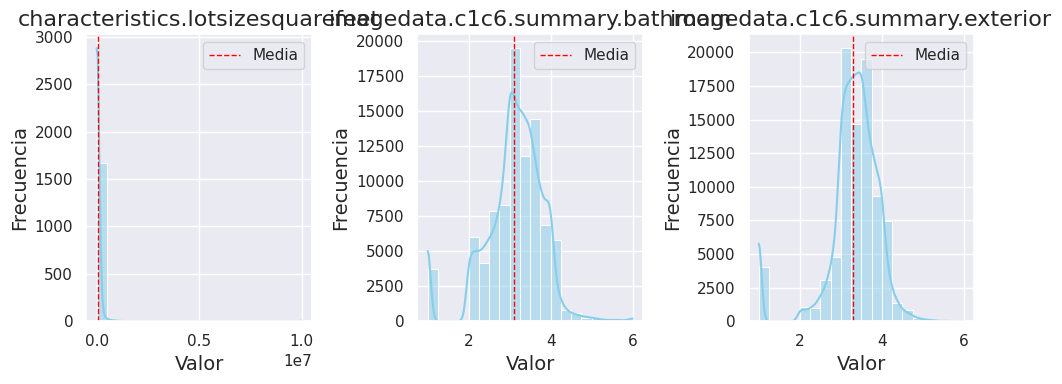

In [23]:
fig, axes = plt.subplots(1,3,figsize=(10,4))

# We will not plot country because it has too many categories.
for i, c in enumerate(df_train.columns[1:4]):
    ax = axes.reshape(-1)[i]
    if df_train[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=df_train,ax=ax)
    else:
        b = sns.histplot(x=c,data=df_train,ax=ax, bins=20, kde=True, color="skyblue")
        ax.set_title(c, fontsize=16)
        ax.set_xlabel('Valor', fontsize=14)
        ax.set_ylabel('Frecuencia', fontsize=14)

        mean = df_train[c].mean()
        median = df_train[c].median()
        ax.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Media')
        ax.legend()

plt.tight_layout()
plt.show();


Ahora que sabemos cómo se ven nuestros datos, es una buena idea verificar cuántos valores perdidos tenemos en cada variable, si es que tenemos.

In [24]:
print(df_train.columns)

Index(['characteristics.lotfeatures', 'characteristics.lotsizesquarefeet',
       'imagedata.c1c6.summary.bathroom', 'imagedata.c1c6.summary.exterior',
       'imagedata.c1c6.summary.interior', 'imagedata.c1c6.summary.kitchen',
       'imagedata.c1c6.summary.property', 'imagedata.features_reso.results',
       'imagedata.q1q6.summary.bathroom', 'imagedata.q1q6.summary.exterior',
       'imagedata.q1q6.summary.interior', 'imagedata.q1q6.summary.kitchen',
       'imagedata.q1q6.summary.property', 'imagedata.room_type_reso.results',
       'imagedata.style.exterior.summary.label',
       'imagedata.style.stories.summary.label', 'listing.dates.closedate',
       'listing.listingid', 'listing.price.closeprice',
       'location.address.censusblock', 'location.address.censustract',
       'location.address.city', 'location.address.countyorparish',
       'location.address.postalcode', 'location.address.postalcodeplus4',
       'location.address.stateorprovince',
       'location.address.stre

In [27]:
renaming = {
    'characteristics.lotfeatures': 'lot_features',
    'characteristics.lotsizesquarefeet': 'lot_size_sqft',
    'imagedata.c1c6.summary.bathroom': 'c_bathroom',
    'imagedata.c1c6.summary.exterior': 'c_exterior',
    'imagedata.c1c6.summary.interior': 'c_interior',
    'imagedata.c1c6.summary.kitchen': 'c_kitchen',
    'imagedata.c1c6.summary.property': 'c_property',
    'imagedata.features_reso.results': 'features_reso',
    'imagedata.q1q6.summary.bathroom': 'q_bathroom',
    'imagedata.q1q6.summary.exterior': 'q_exterior',
    'imagedata.q1q6.summary.interior': 'q_interior',
    'imagedata.q1q6.summary.kitchen': 'q_kitchen',
    'imagedata.q1q6.summary.property': 'q_property',
    'imagedata.room_type_reso.results': 'room_type_reso',
    'imagedata.style.exterior.summary.label': 'style_exterior',
    'imagedata.style.stories.summary.label': 'style_stories',
    'listing.dates.closedate': 'close_date',
    'listing.listingid': 'listing_id',
    'listing.price.closeprice': 'close_price',
    'location.address.censusblock': 'census_block',
    'location.address.censustract': 'census_tract',
    'location.address.city': 'city',
    'location.address.countyorparish': 'county_or_parish',
    'location.address.postalcode': 'postal_code',
    'location.address.postalcodeplus4': 'postal_code_plus4',
    'location.address.stateorprovince': 'state_or_province',
    'location.address.streetdirectionprefix': 'street_direction_prefix',
    'location.address.streetdirectionsuffix': 'street_direction_suffix',
    'location.address.streetname': 'street_name',
    'location.address.streetnumber': 'street_number',
    'location.address.streetsuffix': 'street_suffix',
    'location.address.unitnumber': 'unit_number',
    'location.address.unparsedaddress': 'unparsed_address',
    'location.area.subdivisionname': 'subdivision_name',
    'location.gis.latitude': 'latitude',
    'location.gis.longitude': 'longitude',
    'location.school.highschooldistrict': 'high_school_district',
    'property.propertytype': 'property_type',
    'structure.basement': 'basement',
    'structure.bathroomsfull': 'bathrooms_full',
    'structure.bathroomshalf': 'bathrooms_half',
    'structure.bedroomstotal': 'bedrooms_total',
    'structure.belowgradefinishedarea': 'below_grade_finished_area',
    'structure.belowgradeunfinishedarea': 'below_grade_unfinished_area',
    'structure.cooling': 'cooling',
    'structure.fireplacestotal': 'fireplaces_total',
    'structure.garagespaces': 'garage_spaces',
    'structure.heating': 'heating',
    'structure.livingarea': 'living_area',
    'structure.newconstructionyn': 'new_construction',
    'structure.parkingfeatures': 'parking_features',
    'structure.rooms.roomstotal': 'rooms_total',
    'structure.yearbuilt': 'year_built',
    'tax.zoning': 'zoning',
    'unittypes.unittypetype': 'unit_type'
}

df_train.rename(columns=renaming, inplace=True)

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107437 entries, 0 to 107436
Data columns (total 55 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   lot_features                 42020 non-null   category
 1   lot_size_sqft                1690 non-null    float64 
 2   c_bathroom                   90744 non-null   float64 
 3   c_exterior                   87789 non-null   float64 
 4   c_interior                   93597 non-null   float64 
 5   c_kitchen                    92320 non-null   float64 
 6   c_property                   103055 non-null  float64 
 7   features_reso                104780 non-null  category
 8   q_bathroom                   90708 non-null   float64 
 9   q_exterior                   82565 non-null   float64 
 10  q_interior                   93589 non-null   float64 
 11  q_kitchen                    92292 non-null   float64 
 12  q_property                   101798 non-null